In [20]:
import numpy as np
from numba import cuda, float64, complex128, njit, prange
import os
import matplotlib.pyplot as plt
import scienceplots
from styles import set_plot_style

fig_dir = "./Figures_GPU"
os.makedirs(fig_dir, exist_ok=True)
set_plot_style("prism_rain")


In [21]:
# —————————————————————————————————————————————
# 1) Generar los parámetros (mismo setup que siempre)
# —————————————————————————————————————————————
fc      = 2.4e9
lambda_ = 3e8 / fc
v       = 250 / 3.6 # m/s
fmax    = v / lambda_

M = int(1e6)
t_host = np.linspace(0, 0.25, M, dtype=np.float64)

N = int(1e4)
an_host     = np.ones(N, dtype=np.float64) * np.sqrt(1.0 / N)
thetan_host = (2 * np.pi * np.random.rand(N)).astype(np.float64)
fDn_host    = (fmax * np.cos(2 * np.pi * np.random.rand(N))).astype(np.float64)


In [22]:
# —————————————————————————————————————————————
# 2) Transferir datos a memoria GPU
# —————————————————————————————————————————————
t_dev      = cuda.to_device(t_host)       # vector de tiempos (M,)
an_dev     = cuda.to_device(an_host)      # amplitudes (N,)
thetan_dev = cuda.to_device(thetan_host)  # fases (N,)
fDn_dev    = cuda.to_device(fDn_host)     # Doppler (N,)

# Reservar espacio para H(t) en GPU
H_dev = cuda.device_array(shape=(M,), dtype=np.complex128)

# —————————————————————————————————————————————
# 3) Definir el kernel CUDA
# —————————————————————————————————————————————
@cuda.jit
def rayleigh_kernel(t, an, thetan, fDn, H_out, N):
    """
    Cada hilo calcula H_out[m] = sum_{n=0..N-1} a_n * exp(j*(theta_n - 2*pi*fDn[n]*t[m])).
    t, an, thetan, fDn, y H_out ya están en memoria de dispositivo.
    """
    m = cuda.grid(1)  # índice global del hilo en dimensión 1
    if m >= H_out.size:
        return
    tm = t[m]                 # t[m]
    const2pi = 2.0 * np.pi
    real_acc = 0.0            # acumulador para parte real
    imag_acc = 0.0            # acumulador para parte imaginaria
    # Sumar sobre todos los N paths
    for n in range(N):
        phi = thetan[n] - const2pi * fDn[n] * tm
        c = np.cos(phi)
        s = np.sin(phi)
        a = an[n]
        real_acc += a * c
        imag_acc += a * s
    H_out[m] = real_acc + 1j * imag_acc


# —————————————————————————————————————————————
# 4) Elegir dimensiones de bloque/rejilla y lanzar el kernel
# —————————————————————————————————————————————
threads_per_block = 256
blocks_per_grid   = (M + threads_per_block - 1) // threads_per_block

# Llamada al kernel: cada bloque tiene 256 hilos; hay blocks_per_grid bloques.
rayleigh_kernel[blocks_per_grid, threads_per_block](
    t_dev, an_dev, thetan_dev, fDn_dev, H_dev, N
)

# Esperar a que termine el kernel
cuda.synchronize()

# Copiar H de vuelta a host
H_host = H_dev.copy_to_host()



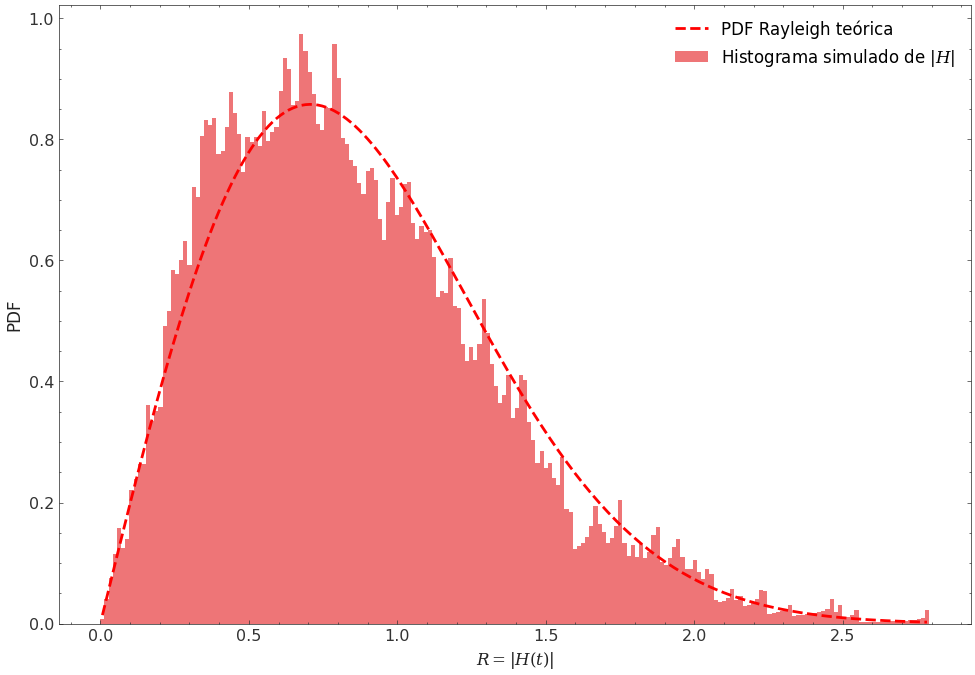

In [23]:
# —————————————————————————————————————————————
# 5) (Opcional) Guardar o usar H_host para graficar / histograma, etc.
# —————————————————————————————————————————————
# Ejemplo: calcular y guardar el histograma del sobre |H|
r = np.abs(H_host)
num_bins = 200
r_max = r.max()
bins = np.linspace(0, r_max, num_bins + 1)
hist_r, edges_r = np.histogram(r, bins=bins, density=True)
centers_r = 0.5 * (edges_r[:-1] + edges_r[1:])
sigma = np.sqrt(0.5)
pdf_rayleigh = (centers_r / (sigma**2)) * np.exp(-centers_r**2 / (2 * sigma**2))


fig, ax = plt.subplots(figsize=(10, 7))
bin_width = centers_r[1] - centers_r[0]

ax.plot(
    centers_r,
    pdf_rayleigh,
    'r--',
    lw=2,
    label=r'PDF Rayleigh teórica'
)

ax.bar(
    centers_r,
    hist_r,
    width=bin_width,
    alpha=0.6,
    #edgecolor='black',
    linewidth=0.5,
    label=r'Histograma simulado de $|H|$'
)

ax.set_xlabel(r'$R = |H(t)|$', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
#ax.set_title('Envelope Rayleigh: empírico vs. teórico (GPU)', fontsize=14)
ax.legend(frameon=False, fontsize=12)

fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'envelope_rayleigh_gpu.pdf'), dpi=300)
plt.show()
plt.close(fig)


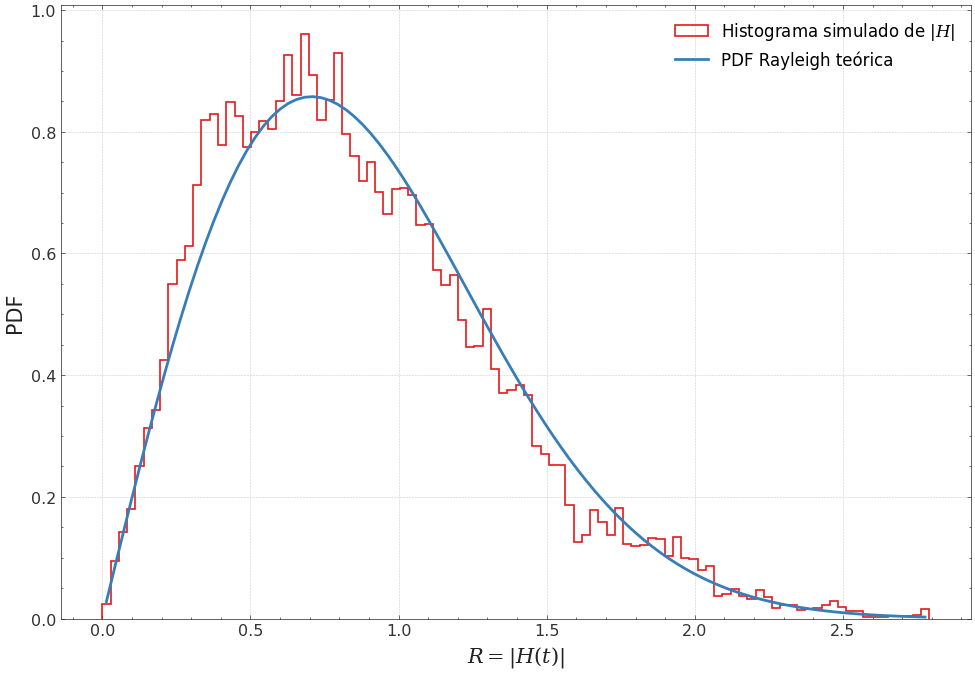

In [24]:


# Compute magnitude |H|
r = np.abs(H_host)
num_bins = 100
r_max = r.max()
bins = np.linspace(0, r_max, num_bins + 1)
hist_r, edges_r = np.histogram(r, bins=bins, density=True)
centers_r = 0.5 * (edges_r[:-1] + edges_r[1:])

# Theoretical Rayleigh PDF
sigma = np.sqrt(0.5)
pdf_rayleigh = (centers_r / (sigma**2)) * np.exp(-centers_r**2 / (2 * sigma**2))


fig, ax = plt.subplots(figsize=(10, 7))

# Plot step histogram
ax.hist(r, 
        bins=bins, 
        density=True, 
        histtype='step', 
        linewidth=1.2, 
        label=r'Histograma simulado de $|H|$')

# Plot theoretical Rayleigh PDF
ax.plot(
    centers_r,
    pdf_rayleigh,
    '-',
    lw=2,
    label=r'PDF Rayleigh teórica'
)

ax.set_xlabel(r'$R = |H(t)|$', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
# ax.set_title('Envelope Rayleigh: empírico vs. teórico (GPU)', fontsize=14)
ax.legend(frameon=False, fontsize=12)
ax.grid(True)

fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'envelope_rayleigh_gpu.pdf'), dpi=300)
plt.show()
plt.close(fig)

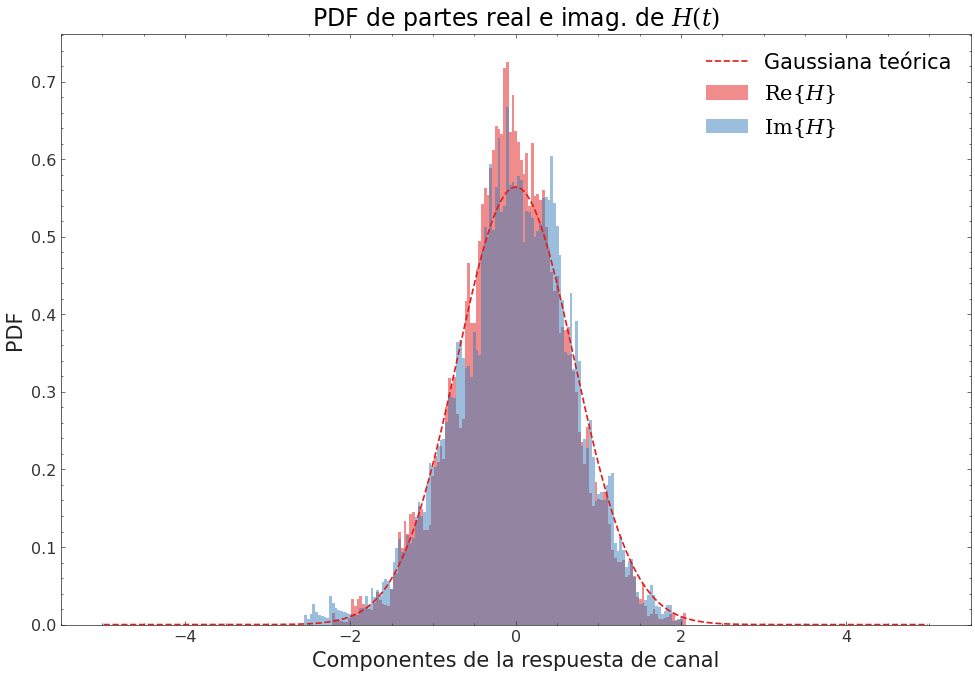

In [25]:
z   = np.linspace(-5, 5, 300)
Dz  = z[1] - z[0]
pdf_im = np.histogram(H_host.imag, bins=z, density=True)[0]
pdf_re = np.histogram(H_host.real, bins=z, density=True)[0]
sigma  = np.sqrt(0.5)
pdf_gauss = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-z**2 / (2 * sigma**2))

# compute empirical histogram
counts_re, edges = np.histogram(H_host.real, bins=z, density=True)
counts_im, _     = np.histogram(H_host.imag, bins=z, density=True)

# true bin‐centers
centers = 0.5 * (edges[:-1] + edges[1:])

# theoretical Gaussian at those centers
pdf_gauss = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-centers**2/(2*sigma**2))

theta = np.linspace(-1.5*np.pi, 1.5*np.pi, 100)
pdf_th = np.histogram(np.angle(H_host), bins=theta, density=True)[0]


LINEWIDTH = 1.2
FONTSIZE  = 15
# —————————————————————————————————————————————
# 2) PDF de la parte real e imaginaria
# —————————————————————————————————————————————

fig, ax = plt.subplots(figsize=(10, 7))

# compute bin‐width
bin_width = centers[1] - centers[0]

# plot histograms for real and imag parts
ax.bar(centers, counts_re, 
       width=bin_width, 
       alpha=0.5,
       label=r'$\mathrm{Re}\{H\}$', 
       #edgecolor='blue', 
       linewidth=0.6)
ax.bar(centers, counts_im, 
       width=bin_width, 
       alpha=0.5,
       label=r'$\mathrm{Im}\{H\}$', 
       #edgecolor='black', 
       linewidth=0.6)

# overlay theoretical Gaussian
ax.plot(centers, pdf_gauss, '--', label='Gaussiana teórica', lw=LINEWIDTH)

# labels, title, legend
ax.set_xlabel('Componentes de la respuesta de canal', fontsize=FONTSIZE)
ax.set_ylabel('PDF', fontsize=FONTSIZE)
ax.set_title('PDF de partes real e imag. de $H(t)$', fontsize=FONTSIZE+2)
ax.legend(frameon=False, fontsize=FONTSIZE)


fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'H_pdf_real_imag.pdf'), dpi=300)
plt.show()
plt.close(fig)


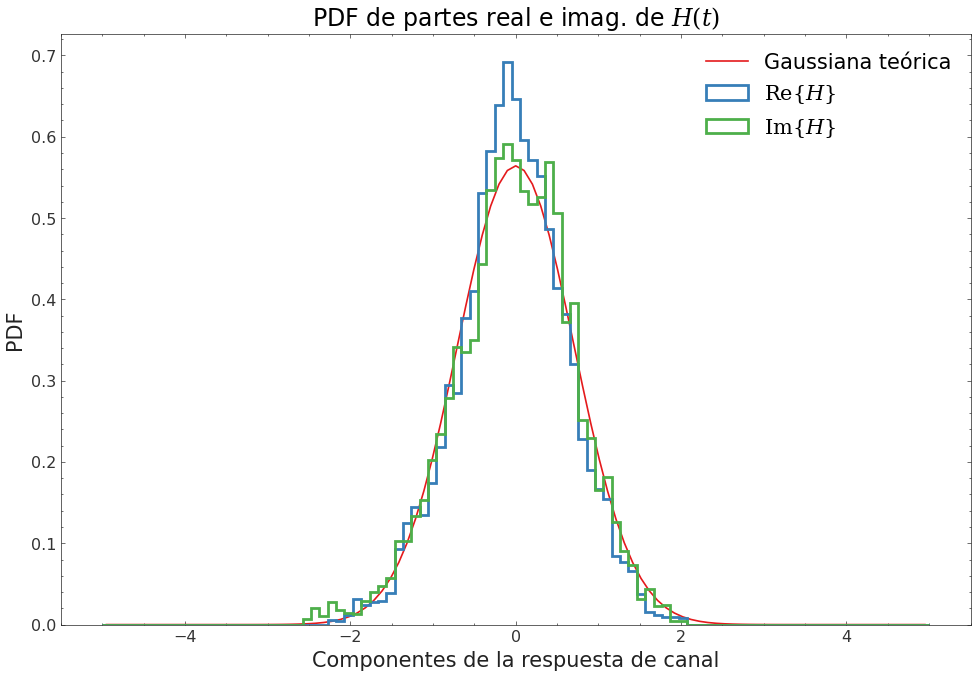

In [26]:
z = np.linspace(-5, 5, 100)
Dz = z[1] - z[0]
counts_re, edges = np.histogram(H_host.real, bins=z, density=True)
counts_im, _ = np.histogram(H_host.imag, bins=z, density=True)

centers = 0.5 * (edges[:-1] + edges[1:])

sigma = np.sqrt(0.5)
pdf_gauss = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-centers**2 / (2 * sigma**2))

LINEWIDTH = 1.2
FONTSIZE = 15

# —————————————————————————————————————————————
# PDF of real and imaginary parts as step histograms
# —————————————————————————————————————————————
fig, ax = plt.subplots(figsize=(10, 7))

# Plot theoretical Gaussian
ax.plot(centers, pdf_gauss, '-', label='Gaussiana teórica', lw=LINEWIDTH)


# Plot step histograms
ax.hist(H_host.real, bins=z, density=True, histtype='step', linewidth=2, label=r'$\mathrm{Re}\{H\}$')
ax.hist(H_host.imag, bins=z, density=True, histtype='step', linewidth=2, label=r'$\mathrm{Im}\{H\}$')


# Labels, title, legend
ax.set_xlabel('Componentes de la respuesta de canal', fontsize=FONTSIZE)
ax.set_ylabel('PDF', fontsize=FONTSIZE)
ax.set_title('PDF de partes real e imag. de $H(t)$', fontsize=FONTSIZE + 2)
ax.legend(frameon=False, fontsize=FONTSIZE)

fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'H_pdf_real_imag.pdf'), dpi=300)
plt.show()
plt.close(fig)

In [27]:
t      = np.linspace(0, 0.25, M)
an     = np.ones(N) * np.sqrt(1/N)
thetan = 2*np.pi * np.random.rand(N)
fDn    = fmax * np.cos(2*np.pi * np.random.rand(N))

# —————————————————————————————————————————————
# Cálculo de H(t) = Σ a_n · exp[j(θ_n − 2π fD_n · t)]
# —————————————————————————————————————————————
@njit(parallel=True, fastmath=True)
def gen_rayleigh(t, an, thetan, fDn):
    M = t.size
    H = np.zeros(M, np.complex128)
    for n in prange(an.size):
        # compute phase for this path
        phase = thetan[n] - 2*np.pi * fDn[n] * t
        H += an[n] * np.exp(1j * phase)
    return H